In [8]:
#Notebook 4- Training pipeline
!pip install -q timm==0.9.2
!pip install -q torchinfo
!pip install -q einops

import os, random, time, json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

#Verifying the GPU
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Torch version: 2.9.0+cu126
CUDA available: True
CUDA device: Tesla T4


In [ ]:
#Cell 2- Config
ROOT="/content/drive/MyDrive/food-10/food-10"
CSV_DIR=os.path.join(ROOT, "prepared_splits")
OUT_DIR="/content/food10_outputs"
DRIVE_OUT_DIR=os.path.join(ROOT,"outputs")    #optional copy to Drive
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(DRIVE_OUT_DIR, exist_ok=True)

SEED=42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
set_seed(SEED)

CFG={
    "img_size": 224,
    "batch_size": 32,      #we can adjust down if OOM: try 16 or 8
    "epochs": 12,
    "lr": 3e-4,
    "weight_decay": 1e-4,
    "num_workers": min(8, os.cpu_count() or 4),
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "model_name": "resnet50",
    "save_every": 1
}
print("Config:", CFG)

Config: {'img_size': 224, 'batch_size': 32, 'epochs': 12, 'lr': 0.0003, 'weight_decay': 0.0001, 'num_workers': 2, 'device': 'cuda', 'model_name': 'resnet50', 'save_every': 1}


In [ ]:
#Cell 3- Load CSVs and inspect
train_df=pd.read_csv(os.path.join(CSV_DIR,"train.csv"))
val_df=pd.read_csv(os.path.join(CSV_DIR,"val.csv"))

print("Train rows:",len(train_df))
print("Val rows  :",len(val_df))
print("Columns:",train_df.columns.tolist())

#ensure fullpath exists for first few rows
import os
for p in train_df['fullpath'].sample(3, random_state=SEED).tolist():
    print(p, os.path.exists(p))

Train rows: 6000
Val rows  : 1500
Columns: ['path', 'class', 'fullpath', 'label']
/content/drive/MyDrive/food-10/food-10/images/grilled_cheese_sandwich/3070263.jpg True
/content/drive/MyDrive/food-10/food-10/images/onion_rings/2448474.jpg True
/content/drive/MyDrive/food-10/food-10/images/ravioli/268181.jpg True


In [ ]:
#Cell 4-Dataset and transforms
from torchvision.transforms import Compose, RandomResizedCrop, RandomHorizontalFlip, ColorJitter, ToTensor, Normalize, Resize, CenterCrop

IMG_SIZE=CFG['img_size']
train_transforms=Compose([
    RandomResizedCrop(IMG_SIZE),
    RandomHorizontalFlip(),
    ColorJitter(0.2,0.2,0.2,0.05),
    ToTensor(),
    Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

val_transforms=Compose([
    Resize(int(IMG_SIZE*1.15)),
    CenterCrop(IMG_SIZE),
    ToTensor(),
    Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

class Food10Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df=df.reset_index(drop=True)
        self.transform=transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row=self.df.iloc[idx]
        img=Image.open(row['fullpath']).convert('RGB')
        if self.transform:
            img=self.transform(img)
        label=int(row['label'])
        return img, label

In [ ]:
#Cell 5-Create dataloaders
train_ds=Food10Dataset(train_df,transform=train_transforms)
val_ds=Food10Dataset(val_df,transform=val_transforms)
train_loader=DataLoader(train_ds, batch_size=CFG['batch_size'],shuffle=True,
                          num_workers=CFG['num_workers'],pin_memory=(CFG['device']=='cuda'))
val_loader=DataLoader(val_ds, batch_size=CFG['batch_size'],shuffle=False,
                          num_workers=CFG['num_workers'],pin_memory=(CFG['device']=='cuda'))
print("Train batches:", len(train_loader), "Val batches:",len(val_loader))

Train batches: 188 Val batches: 47


In [ ]:
#Cell 6- Model & optimization setup
device=torch.device(CFG['device'])
num_classes=train_df['label'].nunique()
def get_resnet50(num_classes,pretrained=True):
    model=models.resnet50(pretrained=pretrained)
    in_features=model.fc.in_features
    model.fc=nn.Linear(in_features, num_classes)
    return model
model=get_resnet50(num_classes=num_classes,pretrained=True).to(device)
print(model.fc)
criterion=nn.CrossEntropyLoss()
optimizer=optim.AdamW(model.parameters(),lr=CFG['lr'],weight_decay=CFG['weight_decay'])
#Scheduler: cosine annealing for full epochs
scheduler=optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=CFG['epochs'],eta_min=1e-6)
#mixed precision scaler
scaler=torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 175MB/s]


Linear(in_features=2048, out_features=10, bias=True)


/tmp/ipython-input-3551895705.py:16: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler=torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


In [ ]:
#The 7th cell- We shall train & validate functions
from sklearn.metrics import f1_score
def train_one_epoch(model, loader, optimizer, criterion, device, scaler):
    model.train()
    losses=[]
    preds=[]
    targets=[]
    loop=tqdm(loader,desc="Train",leave=False)
    for imgs,lbls in loop:
        imgs=imgs.to(device,non_blocking=True)
        lbls=lbls.to(device,non_blocking=True)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
            out=model(imgs)
            loss=criterion(out,lbls)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        losses.append(loss.item())
        preds.extend(out.argmax(dim=1).detach().cpu().numpy().tolist())
        targets.extend(lbls.detach().cpu().numpy().tolist())
        loop.set_postfix(loss=np.mean(losses))
    mean_loss=float(np.mean(losses))
    f1=f1_score(targets,preds,average='macro')
    return mean_loss, f1

def validate(model, loader, criterion, device):
    model.eval()
    losses=[]
    preds=[]
    targets=[]
    with torch.no_grad():
        loop=tqdm(loader,desc="Val  ",leave=False)
        for imgs, lbls in loop:
            imgs=imgs.to(device,non_blocking=True)
            lbls=lbls.to(device,non_blocking=True)
            out=model(imgs)
            loss=criterion(out,lbls)
            losses.append(loss.item())
            preds.extend(out.argmax(dim=1).detach().cpu().numpy().tolist())
            targets.extend(lbls.detach().cpu().numpy().tolist())
    mean_loss=float(np.mean(losses))
    f1=f1_score(targets,preds,average='macro')
    return mean_loss,f1,targets,preds

In [ ]:
#cell number 8- Training loop
best_f1=0.0
history={"train_loss":[],"train_f1":[],"val_loss":[],"val_f1":[]}
best_path=os.path.join(OUT_DIR, "best_resnet50.pth")
for epoch in range(CFG['epochs']):
    print(f"\n=== Epoch {epoch+1}/{CFG['epochs']} ===")
    tr_loss,tr_f1=train_one_epoch(model,train_loader,optimizer,criterion,device,scaler)
    val_loss,val_f1,val_targets,val_preds=validate(model,val_loader,criterion,device)
    scheduler.step()

    history['train_loss'].append(tr_loss); history['train_f1'].append(tr_f1)
    history['val_loss'].append(val_loss); history['val_f1'].append(val_f1)
    print(f"Epoch {epoch+1} Train loss {tr_loss:.4f} f1 {tr_f1:.4f} | Val loss {val_loss:.4f} f1 {val_f1:.4f}")
    #checkpoint if improved
    if val_f1>best_f1:
        best_f1=val_f1
        ckpt={
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "scheduler_state": scheduler.state_dict(),
            "epoch": epoch,
            "best_f1": best_f1,
            "cfg": CFG}
        torch.save(ckpt, best_path)
        #also copying to Drive outputs dir
        torch.save(ckpt, os.path.join(DRIVE_OUT_DIR, "best_resnet50.pth"))
        print("Saved best model with val_f1:", best_f1)

    #saving the history every epoch
    with open(os.path.join(OUT_DIR, "history.json"), "w") as f:
        json.dump(history, f)
    with open(os.path.join(DRIVE_OUT_DIR, "history.json"), "w") as f:
        json.dump(history, f)
print("\nTraining finished. Best val F1:", best_f1)


=== Epoch 1/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 1 Train loss 1.2014 f1 0.6026 | Val loss 0.7898 f1 0.7191
Saved best model with val_f1: 0.7190921744873713

=== Epoch 2/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 2 Train loss 0.9309 f1 0.6960 | Val loss 0.7987 f1 0.7475
Saved best model with val_f1: 0.7475365826966038

=== Epoch 3/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 3 Train loss 0.8216 f1 0.7305 | Val loss 0.5854 f1 0.7964
Saved best model with val_f1: 0.7963739187222747

=== Epoch 4/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 4 Train loss 0.7449 f1 0.7523 | Val loss 0.7248 f1 0.7564

=== Epoch 5/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 5 Train loss 0.6788 f1 0.7801 | Val loss 0.5664 f1 0.8177
Saved best model with val_f1: 0.8177068067972953

=== Epoch 6/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 6 Train loss 0.6078 f1 0.8061 | Val loss 0.4793 f1 0.8342
Saved best model with val_f1: 0.8342080937711485

=== Epoch 7/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 7 Train loss 0.5061 f1 0.8371 | Val loss 0.4407 f1 0.8541
Saved best model with val_f1: 0.8540860208249283

=== Epoch 8/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 8 Train loss 0.4677 f1 0.8411 | Val loss 0.3797 f1 0.8723
Saved best model with val_f1: 0.8722888432831221

=== Epoch 9/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 9 Train loss 0.3776 f1 0.8731 | Val loss 0.3276 f1 0.9016
Saved best model with val_f1: 0.9015578094106331

=== Epoch 10/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 10 Train loss 0.3354 f1 0.8916 | Val loss 0.3266 f1 0.8981

=== Epoch 11/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):


Epoch 11 Train loss 0.2938 f1 0.9049 | Val loss 0.3275 f1 0.9024
Saved best model with val_f1: 0.9023548931635321

=== Epoch 12/12 ===


Train:   0%|          | 0/188 [00:00<?, ?it/s]/tmp/ipython-input-1092534473.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=='cuda')):
                                                      

Epoch 12 Train loss 0.2881 f1 0.9071 | Val loss 0.3194 f1 0.9009

Training finished. Best val F1: 0.9023548931635321


Validation loss: 0.3275283419705452 Macro F1: 0.9023548931635321
                         precision    recall  f1-score   support

                cannoli       0.98      0.92      0.95       150
                ceviche       0.85      0.89      0.87       150
             crab_cakes       0.85      0.97      0.90       150
          frozen_yogurt       0.99      0.96      0.97       150
                gnocchi       0.83      0.77      0.80       150
grilled_cheese_sandwich       0.93      0.91      0.92       150
            onion_rings       0.95      0.97      0.96       150
              pork_chop       0.88      0.85      0.86       150
                ravioli       0.81      0.81      0.81       150
    spaghetti_bolognese       0.96      0.99      0.97       150

               accuracy                           0.90      1500
              macro avg       0.90      0.90      0.90      1500
           weighted avg       0.90      0.90      0.90      1500



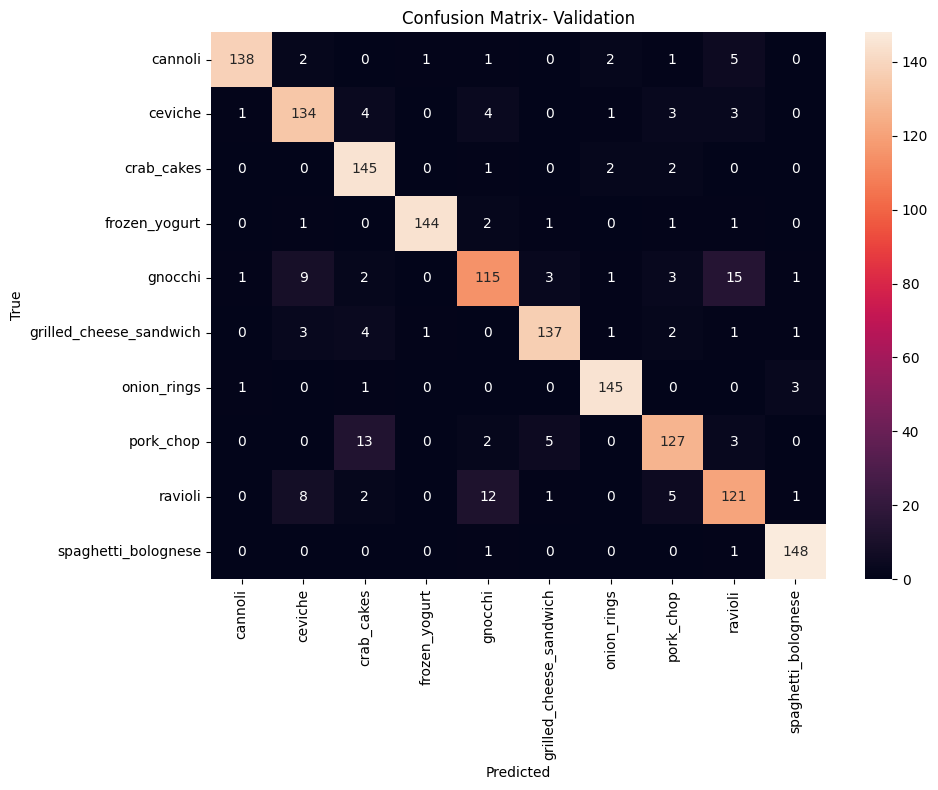

In [ ]:
#Cell 9- Loading the best checkpoint and then evaluating on the validation set
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
ckpt=torch.load(os.path.join(OUT_DIR,"best_resnet50.pth"),map_location=device)
model.load_state_dict(ckpt['model_state'])
model=model.to(device)
model.eval()
val_loss,val_f1,val_targets,val_preds=validate(model,val_loader,criterion,device)
print("Validation loss:",val_loss,"Macro F1:",val_f1)
print(classification_report(val_targets,val_preds,target_names=sorted(train_df['class'].unique())))

cm=confusion_matrix(val_targets,val_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=sorted(train_df['class'].unique()),yticklabels=sorted(train_df['class'].unique()))
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix- Validation")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "confusion_matrix_val.png"),dpi=150)
plt.show()

Using existing local checkpoint at /content/food10_outputs/best_resnet50.pth
Test rows matched: 2500
Number of classes from train mapping: 10
Checkpoint indicates num_classes = 10


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model loaded on device: cuda

Test Macro F1: 0.9368266849751793

Classification report:

                         precision    recall  f1-score   support

                cannoli       0.99      0.96      0.98       250
                ceviche       0.93      0.93      0.93       250
             crab_cakes       0.90      0.92      0.91       250
          frozen_yogurt       1.00      0.98      0.99       250
                gnocchi       0.87      0.89      0.88       250
grilled_cheese_sandwich       0.95      0.93      0.94       250
            onion_rings       1.00      0.98      0.99       250
              pork_chop       0.93      0.92      0.92       250
                ravioli       0.84      0.88      0.86       250
    spaghetti_bolognese       0.98      0.97      0.97       250

               accuracy                           0.94      2500
              macro avg       0.94      0.94      0.94      2500
           weighted avg       0.94      0.94      0.94      2500

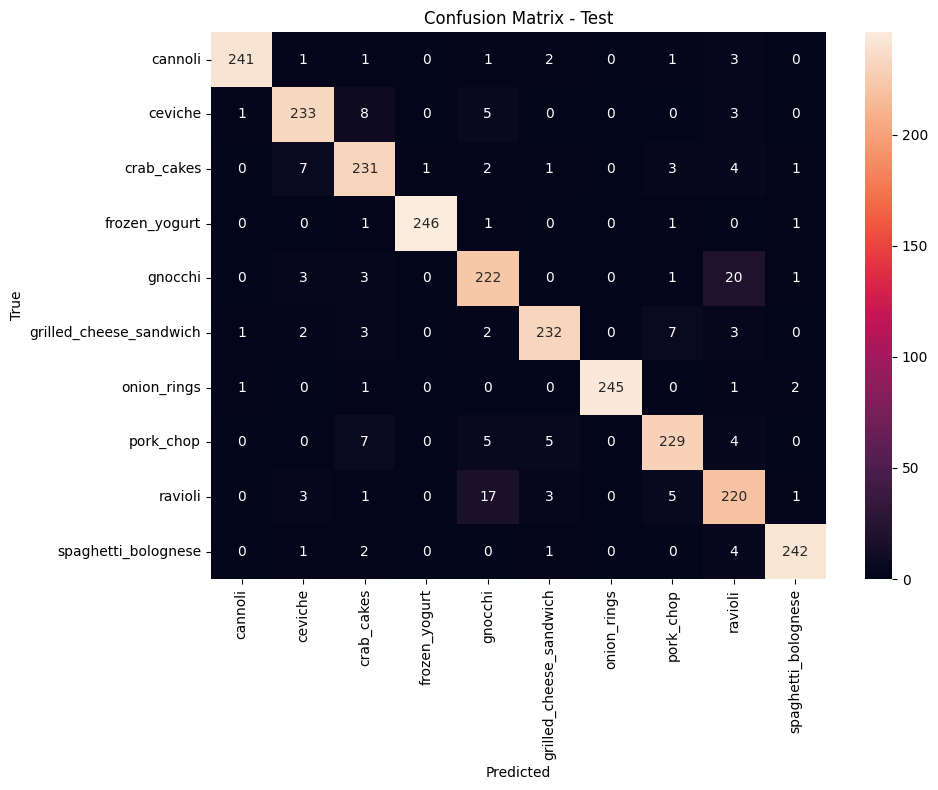

Saved confusion matrix to /content/food10_outputs/confusion_matrix_test.png


In [10]:
# Fixed evaluation: use exact cls2idx mapping from train.csv so labels align with checkpoint
import os, shutil, torch, pandas as pd, numpy as np
from glob import glob
from PIL import Image
from torchvision import models, transforms
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt, seaborn as sns

ROOT = "/content/drive/MyDrive/food-10/food-10"
SPLIT_DIR = os.path.join(ROOT, "prepared_splits")
OUT_DIR = "/content/food10_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

# locate checkpoint on Drive (if not already copied)
matches = glob('/content/drive/MyDrive/**/best_resnet50.pth', recursive=True)
if not matches:
    matches = glob(os.path.join(ROOT, "**/*.pth"), recursive=True)
if not matches:
    raise FileNotFoundError("No checkpoint found on Drive. Re-run training or move the checkpoint to Drive.")
drive_ckpt = matches[0]
local_ckpt = os.path.join(OUT_DIR, "best_resnet50.pth")
if not os.path.exists(local_ckpt):
    shutil.copy(drive_ckpt, local_ckpt)
    print("Copied checkpoint to", local_ckpt)
else:
    print("Using existing local checkpoint at", local_ckpt)

# build df_all by scanning images
IMAGES_DIR = os.path.join(ROOT, "images")
rows=[]
for cls in sorted(os.listdir(IMAGES_DIR)):
    cls_dir = os.path.join(IMAGES_DIR, cls)
    if not os.path.isdir(cls_dir): continue
    for fname in os.listdir(cls_dir):
        if fname.lower().endswith(('.jpg','.jpeg','.png')):
            rows.append({"path": f"{cls}/{fname}", "class": cls, "fullpath": os.path.join(cls_dir, fname)})
df_all = pd.DataFrame(rows)
df_all['no_ext'] = df_all['class'] + "/" + df_all['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# build test_df from test.txt (robust matching)
test_txt = os.path.join(ROOT, "test.txt")
with open(test_txt,'r') as f:
    tlines = [l.strip() for l in f if l.strip()]
matched = []
missing = []
for e in tlines:
    if e in df_all['path'].values:
        matched.append(df_all[df_all['path']==e].iloc[0])
    elif e in df_all['no_ext'].values:
        matched.append(df_all[df_all['no_ext']==e].iloc[0])
    else:
        base = os.path.basename(e).split('.')[0]
        cand = df_all[df_all['path'].str.contains(base)]
        if len(cand) == 1:
            matched.append(cand.iloc[0])
        else:
            missing.append(e)
if missing:
    print("Warning: unmatched test entries (sample):", missing[:10])
test_df = pd.DataFrame(matched).reset_index(drop=True)
print("Test rows matched:", len(test_df))

# load train.csv to get the exact class->label mapping used in training
train_csv = pd.read_csv(os.path.join(SPLIT_DIR, "train.csv"))
if 'label' not in train_csv.columns:
    raise RuntimeError("train.csv missing 'label' column — run Notebook 01 label-fix step.")
cls2idx = dict(zip(train_csv['class'], train_csv['label']))
# ensure values are ints
cls2idx = {k:int(v) for k,v in cls2idx.items()}
# build inverse mapping index->class (ordered by index)
max_idx = max(cls2idx.values())
idx2class = [None] * (max_idx + 1)
for k,v in cls2idx.items():
    idx2class[v] = k
target_names = idx2class
print("Number of classes from train mapping:", len(target_names))

# load the checkpoint and build model matching checkpoint's fc shape
ckpt = torch.load(local_ckpt, map_location='cpu')
# find fc.weight key to infer checkpoint num_classes
ms = ckpt.get('model_state', ckpt)
fc_key = None
for k in ms.keys():
    if k.endswith('fc.weight') or '.fc.weight' in k:
        fc_key = k; break
if fc_key is None:
    raise RuntimeError("Could not find fc.weight key in checkpoint state_dict")

num_classes_ckpt = ms[fc_key].shape[0]
print("Checkpoint indicates num_classes =", num_classes_ckpt)

# build model with that output size
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes_ckpt)
model.load_state_dict(ckpt['model_state'])
model.to(device).eval()
print("Model loaded on device:", device)

# transforms
IMG_SIZE = 224
val_tf = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

# inference: map true classes to labels using cls2idx
all_preds = []
all_trues = []
batch = 64

for i in range(0, len(test_df), batch):
    batch_df = test_df.iloc[i:i+batch]
    imgs = []
    for p in batch_df['fullpath'].tolist():
        imgs.append(val_tf(Image.open(p).convert('RGB')))
    x = torch.stack(imgs).to(device)
    with torch.no_grad():
        out = model(x)
        preds = out.argmax(dim=1).cpu().numpy().tolist()
    all_preds.extend(preds)
    # map true class names to training labels
    trues = [cls2idx[c] for c in batch_df['class'].tolist()]
    all_trues.extend(trues)

# compute metrics
test_f1 = f1_score(all_trues, all_preds, average='macro')
print("\nTest Macro F1:", test_f1)
print("\nClassification report:\n")
print(classification_report(all_trues, all_preds, target_names=target_names))

# confusion matrix and save
cm = confusion_matrix(all_trues, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix - Test")
plt.tight_layout()
savepath = os.path.join(OUT_DIR, "confusion_matrix_test.png")
plt.savefig(savepath, dpi=150)
plt.show()
print("Saved confusion matrix to", savepath)